### Lomb-Scargle Periodogram Tutorial
https://docs.astropy.org/en/stable/timeseries/lombscargle.html

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy import units as u

Create Noisy Sinusoidal Measurements with Random Time Sampling

In [3]:
rand = np.random.default_rng(42)
t = 100 * rand.random(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.standard_normal(100)

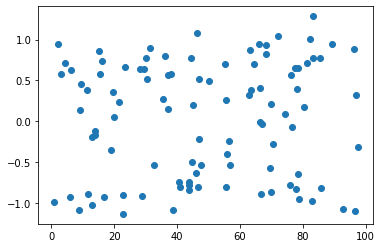

In [4]:
plt.scatter(t, y)

Fit with Lomb-Scargle Method

In [5]:
frequency, power = LombScargle(t, y).autopower()

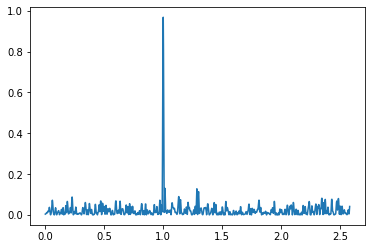

In [6]:
plt.plot(frequency, power)

As expected, there is a peak at a frequency of 1 cycle per unit time.

### Sample Time Series

Text(0, 0.5, 'Flux (mJy)')

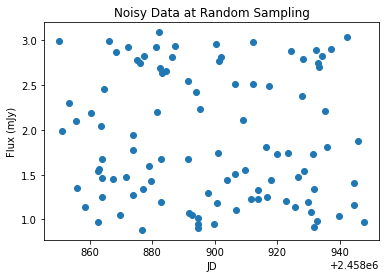

In [7]:
rand2 = np.random.default_rng(10)
t2 = 100 * rand2.random(100) + 2458849
y2 = np.sin(2 * np.pi * t2) + 0.1 * rand2.standard_normal(100) + 2
times = Time(t2, format='jd')
plt.scatter(t2, y2)
plt.title('Noisy Data at Random Sampling')
plt.xlabel('JD')
plt.ylabel('Flux (mJy)')

In [8]:
ts = TimeSeries(time = times, data={'flux': y2 * u.mJy})

Text(0, 0.5, 'Power')

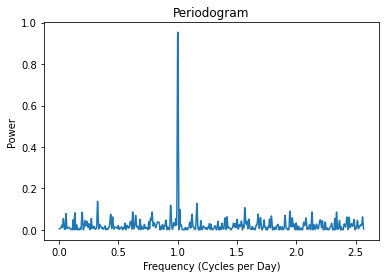

In [9]:
frequency2, power2 = LombScargle(t2*u.day, y2*u.mJy).autopower()
best_freq2 = frequency2[np.argmax(power2)]
plt.plot(frequency2, power2)
plt.title('Periodogram')
plt.xlabel('Frequency (Cycles per Day)')
plt.ylabel('Power')

In [10]:
ts_folded = ts.fold(period=1./best_freq2)

Text(0, 0.5, 'Flux (mJy)')

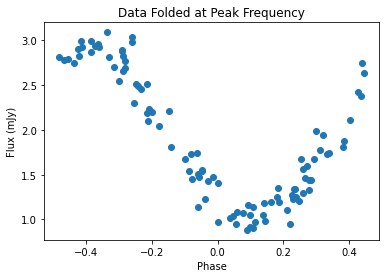

In [11]:
plt.scatter(ts_folded['time'].jd, ts_folded['flux'])
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Flux (mJy)')

## Gaia Light Curve Analysis

In [49]:
from astroquery.gaia import Gaia
from astropy.table import Table, QTable

In [36]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: anilipou
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [43]:
dist_col = 'distance_gspphot'
cartesian = False
ra_col, dec_col = 'ra', 'dec'
dist84_col, dist16_col = 'distance_gspphot_upper', 'distance_gspphot_lower'
gmag_col, bpmag_col, rpmag_col = 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'
num = 100 
query_select = f'SELECT TOP {num} source.{dist_col}, \
source.{ra_col}, source.{dec_col}, source.{dist84_col}, source.{dist16_col}, \
source.{gmag_col}, source.{bpmag_col}, source.{rpmag_col}'

query = f"{query_select} \
FROM gaiadr3.vari_summary AS var \
JOIN gaiadr3.gaia_source AS source ON var.source_id=source.source_id \
WHERE source.has_mcmc_gspphot='true'"
sf = 'Gaia_var.fits'
            

job     = Gaia.launch_job_async(query, output_format='fits')
results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [52]:
import os

In [53]:
stars = QTable([results[ra_col], results[dec_col], results[dist_col], results[dist84_col], results[dist16_col], results[gmag_col], results[bpmag_col], results[rpmag_col]],
                   names=('ra', 'dec', 'dist', 'dist84', 'dist16', 'g', 'bp', 'rp'))

save = True
savefile = f'../{sf}'
if save:
    if os.path.exists(savefile):
        os.remove(savefile)    
    stars.write(savefile, format='fits')

Get Light Curve from Gaia

In [13]:
query = f"SELECT vari.* \
FROM gaiadr3.vari_summary as vari \
WHERE source_id = '376526416902123392'" # short-timescale variable star

job     = Gaia.launch_job_async(query, output_format='fits')
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 1


solution_id,source_id,num_selected_g_fov,mean_obs_time_g_fov,time_duration_g_fov,min_mag_g_fov,max_mag_g_fov,mean_mag_g_fov,median_mag_g_fov,range_mag_g_fov,trimmed_range_mag_g_fov,std_dev_mag_g_fov,skewness_mag_g_fov,kurtosis_mag_g_fov,mad_mag_g_fov,abbe_mag_g_fov,iqr_mag_g_fov,stetson_mag_g_fov,std_dev_over_rms_err_mag_g_fov,outlier_median_g_fov,num_selected_bp,mean_obs_time_bp,time_duration_bp,min_mag_bp,max_mag_bp,mean_mag_bp,median_mag_bp,range_mag_bp,trimmed_range_mag_bp,std_dev_mag_bp,skewness_mag_bp,kurtosis_mag_bp,mad_mag_bp,abbe_mag_bp,iqr_mag_bp,stetson_mag_bp,std_dev_over_rms_err_mag_bp,outlier_median_bp,num_selected_rp,mean_obs_time_rp,time_duration_rp,min_mag_rp,max_mag_rp,mean_mag_rp,median_mag_rp,range_mag_rp,trimmed_range_mag_rp,std_dev_mag_rp,skewness_mag_rp,kurtosis_mag_rp,mad_mag_rp,abbe_mag_rp,iqr_mag_rp,stetson_mag_rp,std_dev_over_rms_err_mag_rp,outlier_median_rp,in_vari_classification_result,in_vari_rrlyrae,in_vari_cepheid,in_vari_planetary_transit,in_vari_short_timescale,in_vari_long_period_variable,in_vari_eclipsing_binary,in_vari_rotation_modulation,in_vari_ms_oscillator,in_vari_agn,in_vari_microlensing,in_vari_compact_companion
,,,d,d,mag,mag,mag,mag,mag,mag,mag,,,mag,,mag,,,,,d,d,mag,mag,mag,mag,mag,mag,mag,,,mag,,mag,,,,,d,d,mag,mag,mag,mag,mag,mag,mag,,,mag,,mag,,,,,,,,,,,,,,,
int64,int64,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
375316653866487564,376526416902123392,46,2290.9462597207066,1003.2978,12.371773,12.60295,12.470518,12.4529,0.23117752,0.21875972,0.07995764,0.19997245,-1.6081529,0.106928006,1.1102824,0.16757277,41.287693,73.22857,241.7095,47,2260.208929847744,1003.2978,12.658779,12.8984375,12.764891,12.752957,0.23965815,0.22484615,0.082581066,0.21528685,-1.5996836,0.11323516,1.1812669,0.17358167,18.62618,50.889362,87.29026,47,2260.209017527029,1003.29785,11.819671,12.133981,12.007671,11.998183,0.31431007,0.20107022,0.08039226,0.074037224,-1.1274484,0.101345256,1.0453221,0.16217582,20.448362,53.43555,88.513374,False,False,False,False,True,False,False,False,False,False,False,False


In [14]:
retrieval_type = 'EPOCH_PHOTOMETRY'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink  = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, format='votable', output_file=None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')


The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 376526416902123392.xml


In [15]:
product     = datalink[dl_keys[0]][0]
product_tb  = product.to_table()                  # Export to Astropy Table object.
source_ids  = list(set(product_tb['source_id']))  # Detect source_ids.
print(f' There is data for the following Source ID:')
for source_id in source_ids:
    print(f'* {source_id}')

 There is data for the following Source ID:
* 376526416902123392


#### Light Curve Analysis

In [16]:
gaia_t, gaia_f, gaia_m = product_tb['time'], product_tb['mag'], product_tb['mag']
gaia_g, gaia_r, gaia_b = product_tb['band']=='G', product_tb['band']=='RP', product_tb['band']=='BP'
gaia_gmed, gaia_rmed, gaia_bmed = np.nanmedian(gaia_f[gaia_g]), np.nanmedian(gaia_f[gaia_r]), np.nanmedian(gaia_f[gaia_b])

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


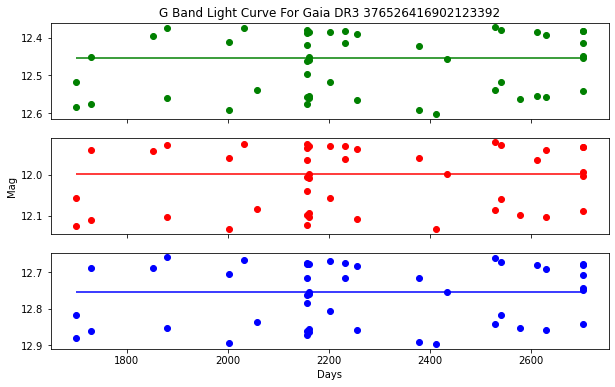

In [17]:
fig, ax = plt.subplots(3, figsize=[10,6], sharex=True)

ax[0].scatter(gaia_t[gaia_g], gaia_f[gaia_g], color='g')
ax[0].hlines(gaia_gmed, gaia_t[gaia_g][0], gaia_t[gaia_g][-1], color='g')
ax[1].scatter(gaia_t[gaia_r], gaia_f[gaia_r], color='r')
ax[1].hlines(gaia_rmed, gaia_t[gaia_r][0], gaia_t[gaia_r][-1], color='r')
ax[2].scatter(gaia_t[gaia_b], gaia_f[gaia_b], color='b')
ax[2].hlines(gaia_bmed, gaia_t[gaia_b][0], gaia_t[gaia_b][-1], color='b')


ax[0].set_title(f'G Band Light Curve For Gaia DR3 {source_ids[0]}')
ax[2].set_xlabel('Days')
ax[1].set_ylabel('Mag')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

In [18]:
gaia_gtime, gaia_rtime, gaia_btime = Time(gaia_t[gaia_g], format='mjd'), Time(gaia_t[gaia_r], format='mjd'), Time(gaia_t[gaia_b], format='mjd') # not in mjd, but in days?
gaia_gflux, gaia_rflux, gaia_bflux = np.array(gaia_f[gaia_g])*u.electron/u.s, np.array(gaia_f[gaia_r])*u.electron/u.s, np.array(gaia_f[gaia_b])*u.electron/u.s

In [19]:
gaia_gts = TimeSeries(time = gaia_gtime, data={'flux' : gaia_gflux})
gaia_rts = TimeSeries(time = gaia_rtime, data={'flux' : gaia_rflux})
gaia_bts = TimeSeries(time = gaia_btime, data={'flux' : gaia_bflux})

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 48 of "dubious year (Note 3)"
  ErfaWarning)
/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 45 of "dubious year (Note 3)"
  ErfaWarning)
/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 47 of "dubious year (Note 3)"
  ErfaWarning)


/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)


Text(0, 0.5, 'Power')

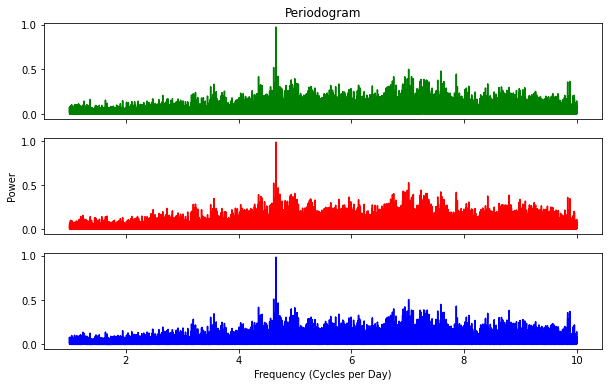

In [20]:
gaia_gfreq, gaia_gpower = LombScargle(gaia_gtime, gaia_gflux.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=10/u.d)
gaia_rfreq, gaia_rpower = LombScargle(gaia_rtime, gaia_rflux.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=10/u.d)
gaia_bfreq, gaia_bpower = LombScargle(gaia_btime, gaia_bflux.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=10/u.d)

gaia_gbestfreq = gaia_gfreq[np.argmax(gaia_gpower)]
gaia_rbestfreq = gaia_rfreq[np.argmax(gaia_rpower)]
gaia_bbestfreq = gaia_bfreq[np.argmax(gaia_bpower)]

fig, ax = plt.subplots(3, figsize=[10,6], sharex=True)

ax[0].plot(gaia_gfreq, gaia_gpower, color='g')
ax[1].plot(gaia_rfreq, gaia_rpower, color='r')
ax[2].plot(gaia_bfreq, gaia_bpower, color='b')
ax[0].set_title('Periodogram')
ax[2].set_xlabel('Frequency (Cycles per Day)')
ax[1].set_ylabel('Power')

In [21]:
print(1/gaia_gbestfreq)
print(1/gaia_rbestfreq)
print(1/gaia_bbestfreq)

0.21443037379631397 d
0.21443037659094963 d
0.21443037603948992 d


This is the same period found in https://arxiv.org/pdf/2206.05591.pdf (p. 10)

In [22]:
gaia_gts_folded = gaia_gts.fold(period=1./gaia_gbestfreq, normalize_phase=True, epoch_phase=0.25)
gaia_rts_folded = gaia_rts.fold(period=1./gaia_rbestfreq, normalize_phase=True, epoch_phase=0.25)
gaia_bts_folded = gaia_bts.fold(period=1./gaia_bbestfreq, normalize_phase=True, epoch_phase=0.25)

Text(0, 0.5, 'Residual Flux (electrons/s)')

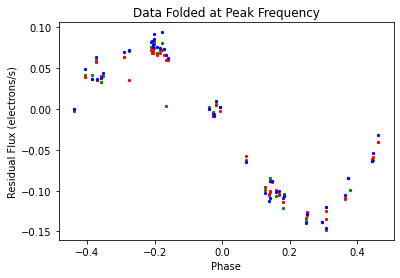

In [25]:
plt.scatter(gaia_gts_folded['time'], gaia_gmed*u.electron/u.s - gaia_gts_folded['flux'], c = 'g', s=5)
plt.scatter(gaia_rts_folded['time'], gaia_rmed*u.electron/u.s - gaia_rts_folded['flux'], c = 'r', s=5)
plt.scatter(gaia_bts_folded['time'], gaia_bmed*u.electron/u.s - gaia_bts_folded['flux'], c = 'b', s=5)
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Residual Flux (electrons/s)')

In [33]:
x=None

In [35]:
if not x:
    print('1')

1
